In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

1. Data cleaning including missing values, outliers and multi-collinearity.
using pandas and numpy we will find the null values and outliers, then check the number of datatypes and check the colinearity of the data pairs


In [2]:
data = pd.read_csv(r"C:\Users\aryan\OneDrive\Desktop\Fraud.csv")

In [5]:
print(data.isnull().sum())
data.isnull().values.any()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


False

In [7]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
# Let us begin with checking if the data is balanced or not

legit = len(data[data.isFraud == 0])
fraud = len(data[data.isFraud == 1])
legit_percent = (legit / (fraud + legit)) * 100
fraud_percent = (fraud / (fraud + legit)) * 100

print("Number of Legit transactions: ", legit)
print("Number of Fraud transactions: ", fraud)
print("Percentage of Legit transactions: {:.4f} %".format(legit_percent))
print("Percentage of Fraud transactions: {:.4f} %".format(fraud_percent))

Number of Legit transactions:  6354407
Number of Fraud transactions:  8213
Percentage of Legit transactions: 99.8709 %
Percentage of Fraud transactions: 0.1291 %


From this we can see that the data is highly imbalanced with legitimate transactions vastly outnumbering fraudulent ones. This is common in fraud detection problems where fraudulent activities are rare compared to normal activities.

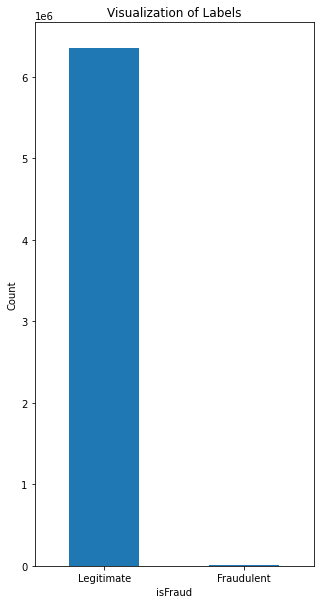

In [11]:
# Let us represent this in a graph to show the difference
plt.figure(figsize=(5,10))
labels = ["Legitimate", "Fraudulent"]
count_classes = data.value_counts(data['isFraud'], sort= True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("Visualization of Labels")
plt.ylabel("Count")
plt.xticks(range(2), labels)
plt.show()

Next we will find the outliers

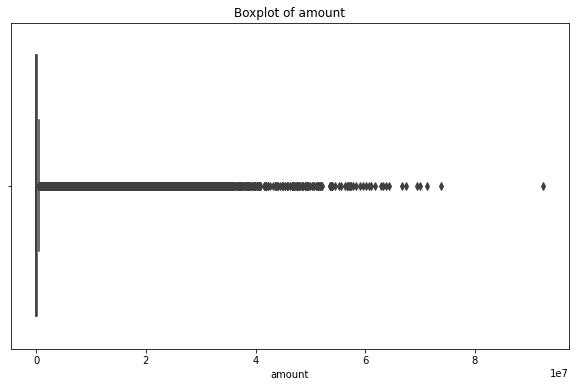

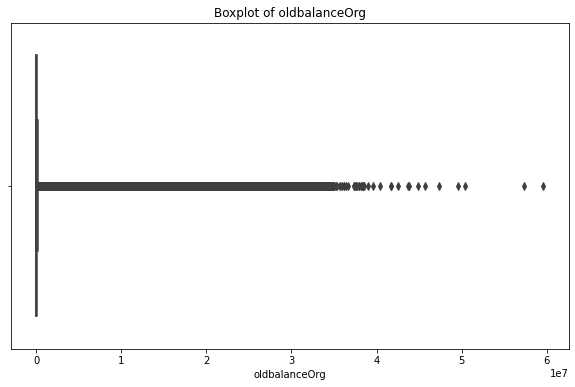

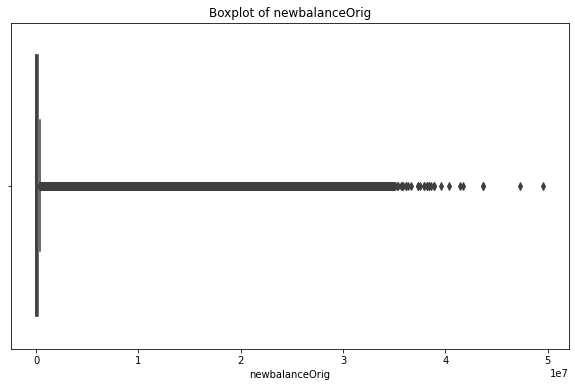

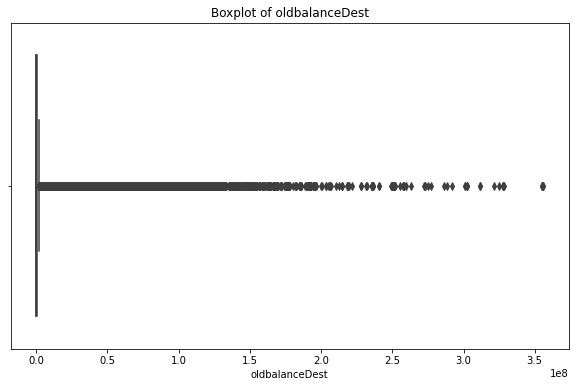

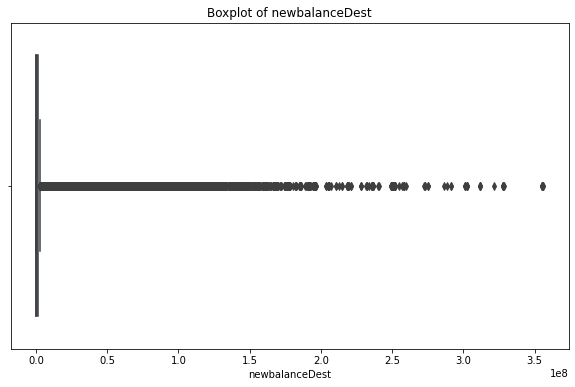

In [14]:
import seaborn as sns
numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
for column in numeric_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

In [16]:
#creating a copy of original dataset to train and test models this is done for label encoding

new_data=data.copy()
new_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [18]:
# As we saw earlier there are 3 columns with datatype object

objList = new_data.select_dtypes(include = "object").columns
print (objList)

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


In [19]:
# Label Encoding for object to numeric conversion
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    new_data[feat] = le.fit_transform(new_data[feat].astype(str))

print (new_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int32  
 2   amount          float64
 3   nameOrig        int32  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int32  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int32(3), int64(3)
memory usage: 461.2 MB
None


In [21]:
new_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


#We are going to use Variance Inflation Factor which measures the extent to which the variance of an estimated regression coefficient increases because of multicollinearity. High VIF values (typically above 5 or 10) indicate multicollinearity.


In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(data):

    vif = pd.DataFrame()
    vif["variables"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

    return(vif)

calc_vif(new_data)

,variables,VIF
0,step,2.791610
1,type,4.467405
2,amount,4.149312
3,nameOrig,2.764234
4,oldbalanceOrg,576.803777
5,newbalanceOrig,582.709128
6,nameDest,3.300975
7,oldbalanceDest,73.349937
8,newbalanceDest,85.005614
9,isFraud,1.195305


From this we see oldbalanceOrg and newbalanceOrig, oldbalanceDest and newbalanceDest, nameDest and nameOrig. Have high colinearity and are correlated, Hence we will combine these values while dropping the other values

In [24]:
new_data['Actual_amount_orig'] = new_data.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
new_data['Actual_amount_dest'] = new_data.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
new_data['TransactionPath'] = new_data.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

#Dropping columns
new_data = new_data.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

calc_vif(new_data)

,variables,VIF
0,type,2.687803
1,amount,3.818902
2,isFraud,1.184479
3,isFlaggedFraud,1.002546
4,Actual_amount_orig,1.307910
5,Actual_amount_dest,3.754335
6,TransactionPath,2.677167


<AxesSubplot:>

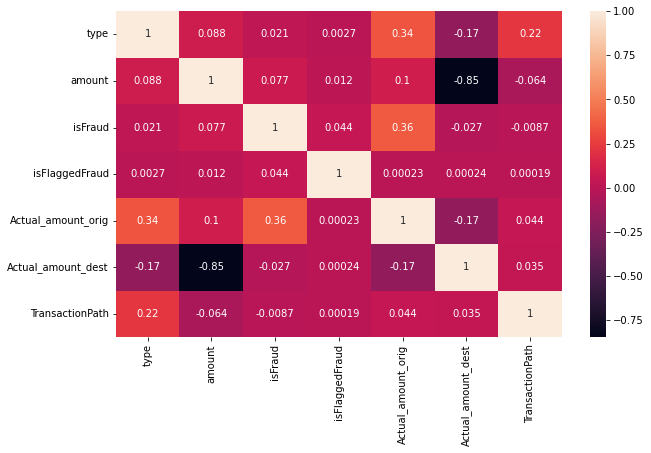

In [25]:
# Let us use a heatmap distribution to show to multi-colinearity
corr=new_data.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

Next let us train the data and test it with an isolated forest method and using this method we can run an anomaly check and proceed with Classification report, confusion matrix, and ROC-AUC. The ROC-AUC score indicates how well the model is distinguishing between normal and fraudulent transactions.

In [26]:
# Convert categorical 'type' column to dummy variables this is done to better fit the isolated forest
data = pd.get_dummies(data, columns=['type'], drop_first=True)

In [27]:
# Feature engineering: create new feature for balance difference
data['balance_difference'] = data['oldbalanceOrg'] - data['newbalanceOrig']

In [28]:
# Select relevant features (excluding 'isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest')
features = data.drop(columns=['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'])

In [62]:
# Fit the Isolation Forest this is done to view predictions
model = IsolationForest(n_estimators=100, contamination=0.00129, random_state=42)
model.fit(features)

IsolationForest(contamination=0.00129, random_state=42)

In [30]:
# Predict anomalies (-1 for anomalies, 1 for normal)
predictions = model.predict(features)

In [31]:
data['anomaly'] = np.where(predictions == -1, 1, 0)

In [32]:
# To view anomaly data
predictions = model.predict(features)
data['anomaly'] = np.where(predictions == -1, 1, 0)
print(data[['anomaly']])


         anomaly
0              0
1              0
2              0
3              0
4              0
...          ...
6362615        0
6362616        0
6362617        1
6362618        0
6362619        0

[6362620 rows x 1 columns]


In [33]:
# Count of anomaly data
print(data['anomaly'].value_counts())

0    6354412
1       8208
Name: anomaly, dtype: int64


Next we will check the Classification report, confusion matrix, and ROC-AUC

In [34]:
print(classification_report(data['isFraud'], data['anomaly']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6354407
           1       0.03      0.03      0.03      8213

    accuracy                           1.00   6362620
   macro avg       0.52      0.52      0.52   6362620
weighted avg       1.00      1.00      1.00   6362620



Precision: The ratio of true positive predictions to the total number of positive predictions. It answers the question: "Of all the points predicted as anomalies, how many were actually anomalies?"
        For class 0 (normal): 1.00
        For class 1 (anomaly): 0.03

Recall: The ratio of true positive predictions to the total number of actual positive instances. It answers the question: Of all the actual anomalies, how many did we correctly identify?
        For class 0 (normal): 1.00
        For class 1 (anomaly): 0.03

F1-Score: The harmonic mean of precision and recall, providing a single metric that balances both concerns.
        For class 0 (normal): 1.00
        For class 1 (anomaly): 0.03

Support: The number of actual occurrences of each class in the dataset.
        For class 0 (normal): 6,354,407
        For class 1 (anomaly): 8,213

Accuracy: The ratio of correctly predicted instances (both normal and anomalies) to the total number of instances. Here, it's nearly perfect (1.00).

Macro Avg: The unweighted mean of precision, recall, and F1-score, treating all classes equally regardless of their support.
        Precision, Recall, F1-Score: 0.52, 0.52, 0.52

Weighted Avg: The mean of precision, recall, and F1-score, weighted by the support of each class. This accounts for the class imbalance.
        Precision, Recall, F1-Score: 1.00, 1.00, 1.00 

In [56]:
print("Confusion Matrix:")
cm=confusion_matrix(data['isFraud'], data['anomaly'])
print(cm)

Confusion Matrix:
[[6346474    7933]
 [   7938     275]]


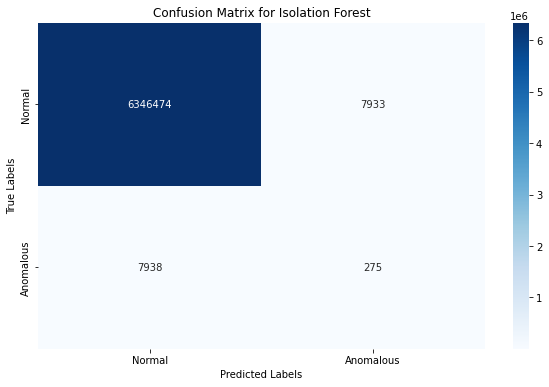

In [57]:
# Visualize the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomalous'], yticklabels=['Normal', 'Anomalous'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Isolation Forest')
plt.show()

In [58]:
print("ROC-AUC Score:", roc_auc_score(data['isFraud'], data['anomaly']))

ROC-AUC Score: 0.5161175384267301


In [65]:
# Invert the scores to make higher scores correspond to anomalies
# Get anomaly scores (lower scores are more anomalous)
anomaly_scores = model.decision_function(features)
anomaly_scores = -anomaly_scores


In [66]:
# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(target, anomaly_scores)
roc_auc = auc(fpr, tpr)

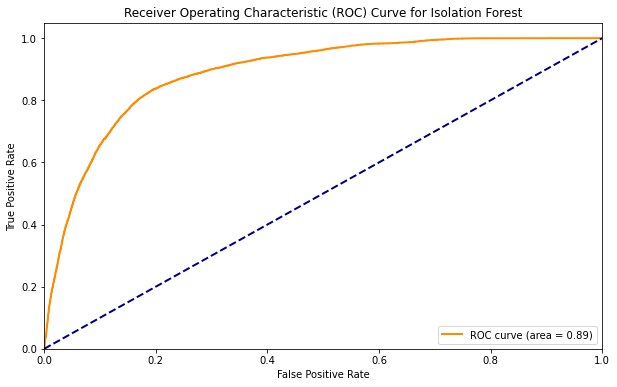

In [67]:
# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Isolation Forest')
plt.legend(loc="lower right")
plt.show()


In [68]:
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.8882683144608079
